# ACADM
[medium-chain acyl-CoA dehydrogenase deficiency (ACADMD)](https://omim.org/entry/201450) is caused by homozygous or compound heterozygous mutation in the medium-chain acyl-CoA dehydrogenase gene (ACADM).
Here we ingest a dataset reported in [Tucci S, et al. (2021) Genotype and residual enzyme activity in medium-chain acyl-CoA dehydrogenase (MCAD) deficiency: Are predictions possible? J Inherit Metab Dis.](https://pubmed.ncbi.nlm.nih.gov/33580884/). Limited clinical information is provided, but we can collect data on genotypes and enzyme activity to show how GPSEA can be used to perform tests of association of genotypes with numerical measurements using a t test.

The authors speak of 
> a severe mutation, c.985G>A (p.Lys329Glu), or a mild mutation, c.199T>C (p.Tyr67His).

We will perform t tests for both of thest variants.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.5.1.dev0


# ACADM
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for ACADM.

In [2]:
gene_symbol = 'ACADM'
mane_tx_id = 'NM_000016.6'
mane_protein_id = 'NP_000007.1' # medium-chain specific acyl-CoA dehydrogenase, mitochondrial isoform a precursor

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator

cohort_name = "ACADM"	


cohort_creator = configure_caching_cohort_creator(hpo)
from gpsea.preprocessing import load_phenopacket_folder
pp_dir = 'phenopackets/'
cohort, qc_results = load_phenopacket_folder(pp_dir, cohort_creator)  
qc_results.summarize()

Individuals Processed: 115individuals [00:54,  2.10individuals/s]
Validated under permissive policy
Showing errors and warnings
Phenopackets
  patient #0
    phenotype-features
     warnings:
     ·No phenotype terms were left after the validation. Revise the phenotype terms and try again
  patient #1
    phenotype-features
     warnings:
     ·No phenotype terms were left after the validation. Revise the phenotype terms and try again
  patient #2
    phenotype-features
     warnings:
     ·No phenotype terms were left after the validation. Revise the phenotype terms and try again
  patient #3
    phenotype-features
     warnings:
     ·No phenotype terms were left after the validation. Revise the phenotype terms and try again
  patient #4
    phenotype-features
     warnings:
     ·No phenotype terms were left after the validation. Revise the phenotype terms and try again
  patient #5
    phenotype-features
     warnings:
     ·No phenotype terms were left after the validation. Revise

In [4]:
from gpsea.view import CohortViewable
viewer = CohortViewable(hpo)
viewer.process(cohort=cohort, transcript_id=mane_tx_id)

<Axes: title={'center': 'Medium-chain specific acyl-CoA dehydrogenase, mitochondrial\ntranscript: NM_000016.6, protein: NP_000007.1'}>

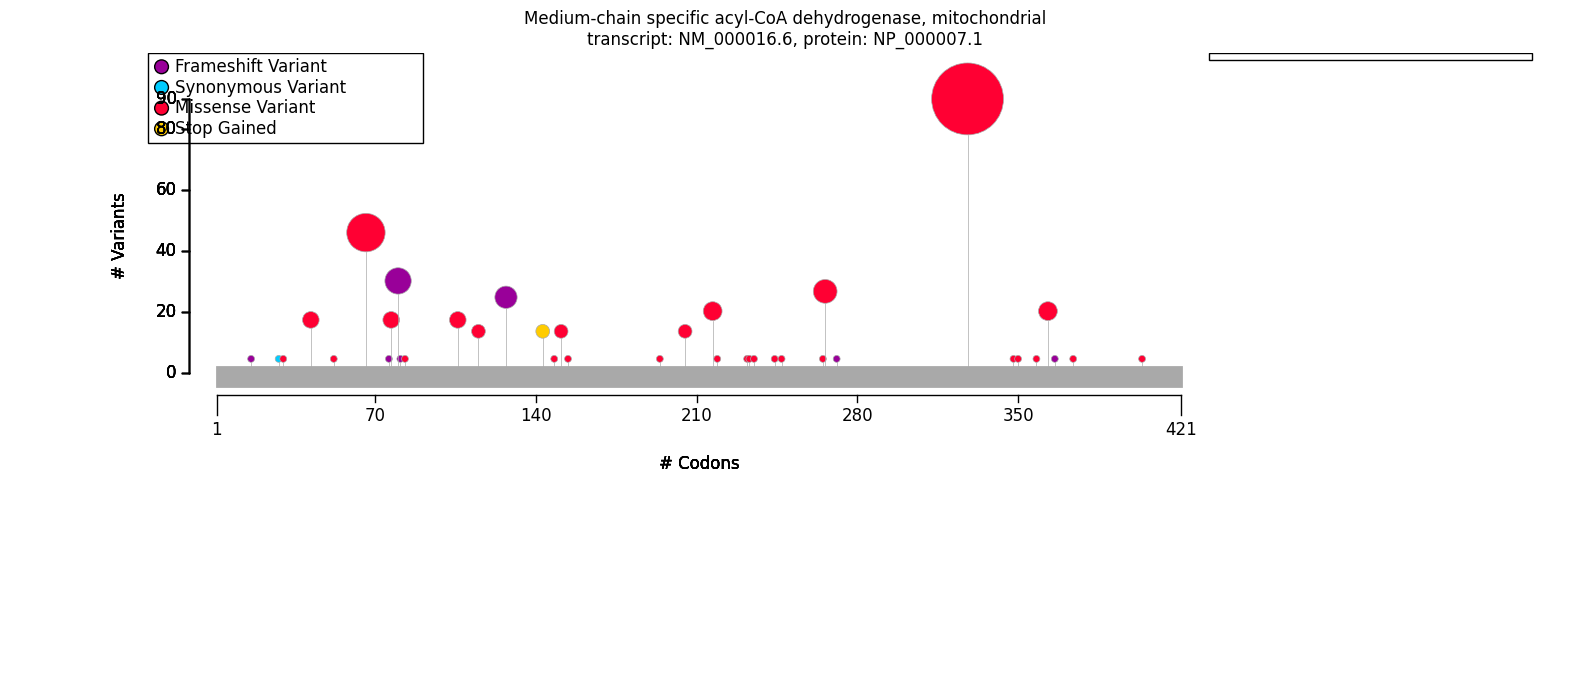

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import VVMultiCoordinateService, configure_default_protein_metadata_service

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(mane_tx_id) 
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)
from gpsea.view import ProteinVisualizable, ProteinVisualizer

pvis = ProteinVisualizable(tx_coordinates=tx_coordinates, protein_meta=protein_meta, cohort=cohort)
drawer = ProteinVisualizer()
drawer.draw_fig(pvis=pvis)

In [10]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates
from gpsea.analysis.predicate.genotype import biallelic_predicate


from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates
is_missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)


Lys329Glu = VariantPredicates.variant_key("1_75761161_75761161_A_G") # c.985A>G	p.Lys329Glu	
Tyr67His = VariantPredicates.variant_key("1_75732724_75732724_T_C") #c.199T>C	p.Tyr67His	

Lys329Glu_homozygote_predicate = biallelic_predicate(
    a_predicate=Lys329Glu,
    b_predicate=~Lys329Glu,
    names=("other", "Lys329Glu"),
    partitions=((0,), (1,2))
)

Tyr67His_homoyzgote_or_ch_predicate = biallelic_predicate(
    a_predicate=Tyr67His,
    b_predicate=~Tyr67His,
    names=("other", "Tyr67His"),
    partitions=((0,1), (2,))
)

print(f"Lys329Glu predicate: {Lys329Glu_homozygote_predicate.display_question()}")
print(f"Tyr67His predicate: {Tyr67His_homoyzgote_or_ch_predicate.display_question()}")

Lys329Glu predicate: Allele group: other/other, other/Lys329Glu OR Lys329Glu/Lys329Glu
Tyr67His predicate: Allele group: other/other OR other/Tyr67His, Tyr67His/Tyr67His


In [12]:
from gpsea.analysis.pscore import MeasurementPhenotypeScorer, PhenotypeScoreAnalysisResult
from gpsea.analysis.pscore.stats import TTestStatistic
from gpsea.analysis.pscore import PhenotypeScoreAnalysis
from gpsea.analysis.predicate.genotype import GenotypePolyPredicate
from gpsea.model import Cohort

def perform_t_test(loinc_id: str,
                   cohort: Cohort,
                   gt_predicate: GenotypePolyPredicate) -> PhenotypeScoreAnalysisResult:
    pheno_scorer = MeasurementPhenotypeScorer.from_measurement_id(
        term_id=loinc_id,
    )
    score_statistic = TTestStatistic()
    score_analysis = PhenotypeScoreAnalysis(
        score_statistic=score_statistic,
    )
    result = score_analysis.compare_genotype_vs_phenotype_score(
        cohort=cohort,
        gt_predicate=gt_predicate,
        pheno_scorer=pheno_scorer,
    )
    return result

# "MCAD Activity%"
This is LOINC code [LOINC:74892-1](https://loinc.org/74892-1).

In [13]:
loinc_id ="LOINC:74892-1"
loinc_label = "MCAD Activity%"
result_Lys329Glu = perform_t_test(loinc_id=loinc_id, cohort=cohort, gt_predicate=Lys329Glu_homozygote_predicate)
print(f"Lys329Glu: t test for {loinc_label}({loinc_id}): {result_Lys329Glu.pval}")
result_Tyr67His = perform_t_test(loinc_id=loinc_id, cohort=cohort, gt_predicate=Tyr67His_homoyzgote_or_ch_predicate)
print(f"Tyr67His: t test for {loinc_label}({loinc_id}): {result_Tyr67His.pval}")


Lys329Glu: t test for MCAD Activity%(LOINC:74892-1): 6.122643015760305e-10
Tyr67His: t test for MCAD Activity%(LOINC:74892-1): 2.0099847817662854e-05


# Lys329Glu
c.985G>A (p.Lys329Glu) is tthe severe mutation according to the authors.

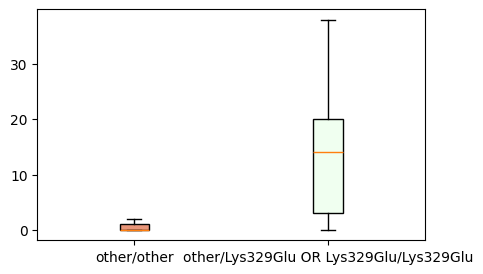

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 3))
result_Lys329Glu.plot_boxplots(gt_predicate=Lys329Glu_homozygote_predicate, ax=ax)

# Tyr67His
c.199T>C (p.Tyr67His) is a mild mutation according to the authors

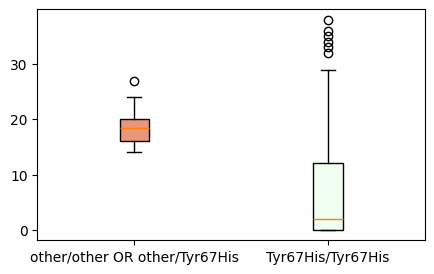

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 3))
result_Tyr67His.plot_boxplots(gt_predicate=Tyr67His_homoyzgote_or_ch_predicate, ax=ax)